## Standardizing Datasets

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MolToSmiles
from scipy.stats import zscore
from tqdm import tqdm
import numpy as np

def load_binding_affinity_dataset(csv_path, 
                                  protein_col_idx, 
                                  smiles_col_idx, 
                                  affinity_col_idx, 
                                  is_log10_affinity=True, 
                                  canonicalize_smiles=True, 
                                  affinity_unit="uM",
                                  delimiter=','):
    """
    Load a protein-ligand binding affinity dataset and preprocess it.

    Args:
        csv_path (str): Path to the CSV file.
        protein_col_idx (int): Column index containing protein sequences.
        smiles_col_idx (int): Column index containing molecule SMILES.
        affinity_col_idx (int): Column index containing binding affinities.
        is_log10_affinity (bool): Whether affinities are in log10. Default is True.
        canonicalize_smiles (bool): Whether to canonicalize SMILES. Default is True.
        delimiter (str): Delimiter for the CSV file. Default is ','.

    Returns:
        pd.DataFrame: Processed DataFrame with columns "seq", "smiles_can",
                      "affinity_uM", "neg_log10_affinity_M", and "affinity_norm".
    """
    # Load dataset
    df = pd.read_csv(csv_path, delimiter=delimiter)

    # Extract relevant columns
    df = df.iloc[:, [protein_col_idx, smiles_col_idx, affinity_col_idx]]
    df.columns = ["seq", "smiles", "affinity"]

    # Canonicalize SMILES
    if canonicalize_smiles:
        def canonicalize(smiles):
            try:
                mol = Chem.MolFromSmiles(smiles)
                return MolToSmiles(mol, canonical=True) if mol else None
            except:
                return None

        from tqdm import tqdm
        tqdm.pandas()
        df["smiles_can"] = df["smiles"].progress_apply(canonicalize)
        df = df[df["smiles_can"].notna()]
    else:
        df["smiles_can"] = df["smiles"]

    # Process affinities
    if not is_log10_affinity:
        # Convert plain Kd value to neg log10(M)
        df["affinity_uM"] = df["affinity"]/(1e3 if affinity_unit == "nM" else 1)
        
        df["neg_log10_affinity_M"] = -df["affinity_uM"].apply(lambda x: np.log10(x/1e6) if x > 0 else np.nan)
    else:
        # Convert log10 values to plain uM for clarity
        df["neg_log10_affinity_M"] = df["affinity"]
        df["affinity_uM"] = df["neg_log10_affinity_M"].apply(lambda x: (10**(-x))*1e6)

    df.dropna(inplace=True)

    # Z-score normalization
    df["affinity_norm"] = zscore(df["neg_log10_affinity_M"])

    # Select and reorder columns
    df = df[["seq", "smiles_can", "affinity_uM", "neg_log10_affinity_M", "affinity_norm"]]

    # Add normalization parameters as columns for reference
    df["affinity_mean"] = df["neg_log10_affinity_M"].mean()
    df["affinity_std"] = df["neg_log10_affinity_M"].std()

    return df.sort_values(by="affinity_norm", ascending=False)

dataset = load_binding_affinity_dataset(
    csv_path="data/raw_data/bindingdb_ic50.csv",
    protein_col_idx=3,
    smiles_col_idx=1,
    affinity_col_idx=4,
    is_log10_affinity=False,  # Specify if Kd values are plain
    canonicalize_smiles=True,
    affinity_unit="nM",
    delimiter=","
)
dataset.to_parquet("data/bindingdb-ic50.parquet", index=False)


## TDC Data

In [ ]:
import pandas as pd
from rdkit import Chem
from tdc.multi_pred import DTI

def process_dataset(name):
    data = DTI(name=name)
    data.harmonize_affinities(mode='mean')
    data.convert_to_log()
    df = data.get_data()
    df['smiles_can'] = df['Drug'].apply(lambda s: Chem.MolToSmiles(Chem.MolFromSmiles(s), isomericSmiles=True, canonical=True) if Chem.MolFromSmiles(s) else None)
    return df[['smiles_can', 'Target', 'Y']].dropna(subset=['smiles_can']).rename(columns={'Target': 'seq', 'Y': 'neg_log_10_affinity'})

datasets = ['BindingDB_Ki', 'BindingDB_Kd', 'BindingDB_IC50', 'DAVIS', 'KIBA']
processed_data = [process_dataset(name) for name in datasets]

binding_db = pd.concat(processed_data[:3]).drop_duplicates().reset_index(drop=True)
binding_db.to_csv("data/bindingdb.csv", index=False)
processed_data[3].to_csv("data/davis.csv", index=False)
processed_data[4].to_csv("data/kiba.csv", index=False)


## PDBbind

In [ ]:
import os
from pathlib import Path
from Bio import PDB
from Bio.PDB.Polypeptide import PPBuilder
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from tqdm import tqdm

ppb = PPBuilder()

def get_protein_sequence(structure):
    """Extract protein sequence from a PDB structure."""
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())
    return sequence

def get_canonical_smiles(mol):
    """Convert RDKit molecule to canonical SMILES."""
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_pdbbind_data(pdbbind_dir, index_file):
    pdbbind_dir = Path(pdbbind_dir).expanduser()
    parser = PDB.PDBParser(QUIET=True)
    data = []
    data_ic50 = []
    data_ki = []
    data_kd = []
    data_equal_only = []
    data_ic50_equal_only = []
    data_ki_equal_only = []
    data_kd_equal_only = []

    # Read the index file
    df_index = pd.read_csv(index_file, sep='\s+', header=None, comment= "#", usecols=[0,1,2,3,4,6,7],
                           names=['PDB_ID', 'Resolution', 'Release_Year', '-logKd/Ki', 'Kd/Ki', 'Reference', 'Ligand_Name'])

    # Get the total number of entries for progress tracking
    total_entries = len(df_index)

    # Use tqdm for progress tracking
    with tqdm(total=total_entries, desc="Processing PDBbind data") as pbar:
        # Create separate lists for different binding types
        
        for _, row in df_index.iterrows():
            pdb_id = row['PDB_ID']
            subdir = pdbbind_dir / pdb_id
            kd_ki_value = row['Kd/Ki']

            if subdir.is_dir():
                # Process protein
                protein_file = subdir / f"{pdb_id}_protein.pdb"
                if protein_file.exists():
                    structure = parser.get_structure(pdb_id, protein_file)
                    sequence = get_protein_sequence(structure)

                # Process ligand
                ligand_file = subdir / f"{pdb_id}_ligand.mol2"
                if ligand_file.exists():
                    mol = Chem.MolFromMol2File(str(ligand_file))
                    if mol is not None:
                        smiles = get_canonical_smiles(mol)

                        # Get binding affinity
                        neg_log_10_affinity = row['-logKd/Ki']

                        # Create entry dictionary
                        entry = {
                            'smiles_can': smiles,
                            'seq': sequence,
                            'neg_log10_affinity_M': neg_log_10_affinity,
                            'affinity_uM': 10**(6-neg_log_10_affinity)
                        }
                        
                        # Add to appropriate list based on binding type
                        data.append(entry)  # Add to the combined list
                        
                        if kd_ki_value.startswith('IC50'):
                            data_ic50.append(entry)
                            if "=" in kd_ki_value:
                                data_ic50_equal_only.append(entry)
                                data_equal_only.append(entry)
                        elif kd_ki_value.startswith('Ki'):
                            data_ki.append(entry)
                            if "=" in kd_ki_value:
                                data_ic50_equal_only.append(entry)
                                data_equal_only.append(entry)
                        elif kd_ki_value.startswith('Kd'):
                            data_kd.append(entry)
                            if "=" in kd_ki_value:
                                data_ic50_equal_only.append(entry)
                                data_equal_only.append(entry)


            pbar.update(1)

    # Create dataframes for each binding type
    df_all = pd.DataFrame(data)
    df_ic50 = pd.DataFrame(data_ic50)
    df_ki = pd.DataFrame(data_ki)
    df_kd = pd.DataFrame(data_kd)
    df_all_equal_only = pd.DataFrame(data)
    df_ic50_equal_only = pd.DataFrame(data_ic50_equal_only)
    df_ki_equal_only = pd.DataFrame(data_ki_equal_only)
    df_kd_equal_only = pd.DataFrame(data_kd_equal_only)
    
    return df_all, df_ic50, df_ki, df_kd, df_all_equal_only, df_ic50_equal_only, df_ki_equal_only, df_kd_equal_only

# Process data from PDBbind refined set
pdbbind_refined_dir = "/Users/tyler/Downloads/refined-set"
index_refined_file = "/Users/tyler/Downloads/PDBbind_v2020_plain_text_index/index/INDEX_refined_data.2020"
df_refined_all, df_refined_ic50, df_refined_ki, df_refined_kd, df_refined_all_equal_only, df_refined_ic50_equal_only, df_refined_ki_equal_only, df_refined_kd_equal_only = process_pdbbind_data(pdbbind_refined_dir, index_refined_file)

df_refined_all.to_parquet('pdbbind-2020-refined.parquet', index=False)
df_refined_ki.to_parquet('pdbbind-2020-refined-ki.parquet', index=False)
df_refined_kd.to_parquet('pdbbind-2020-refined-kd.parquet', index=False)

# Process data from PDBbind general set
pdbbind_general_dir = "/Users/tyler/Downloads/v2020-other-PL"
index_general_file = "/Users/tyler/Downloads/PDBbind_v2020_plain_text_index/index/INDEX_general_PL_data.2020"
df_general_all, df_general_ic50, df_general_ki, df_general_kd, df_general_all_equal_only, df_general_ic50_equal_only, df_general_ki_equal_only, df_general_kd_equal_only = process_pdbbind_data(pdbbind_general_dir, index_general_file)
df_general_all.to_parquet('pdbbind-2020-general.parquet', index=False)
df_general_ic50.to_parquet('pdbbind-2020-general-ic50.parquet', index=False)
df_general_ki.to_parquet('pdbbind-2020-general-ki.parquet', index=False)
df_general_kd.to_parquet('pdbbind-2020-general-kd.parquet', index=False)
df_general_all_equal_only.to_parquet('pdbbind-2020-general-all-equal-only.parquet', index=False)
df_general_ic50_equal_only.to_parquet('pdbbind-2020-general-ic50-equal-only.parquet', index=False)
df_general_ki_equal_only.to_parquet('pdbbind-2020-general-ki-equal-only.parquet', index=False)
df_general_kd_equal_only.to_parquet('pdbbind-2020-general-kd-equal-only.parquet', index=False)


In [12]:
# Read the combined and refined datasets
pdbbind_combined = pd.read_parquet('pdbbind-2020-combined.parquet')
pdbbind_refined = pd.read_parquet('pdbbind-2020-refined.parquet')

# Find rows in combined that are not in refined by comparing seq and smiles_can pairs
general_set = pdbbind_combined[~pdbbind_combined.set_index(['seq', 'smiles_can']).index.isin(
    pdbbind_refined.set_index(['seq', 'smiles_can']).index
)].reset_index(drop=True)

print(f"Combined set size: {len(pdbbind_combined)}")
print(f"Refined set size: {len(pdbbind_refined)}")
print(f"General set size: {len(general_set)}")

# Save the general set
general_set.to_parquet('pdbbind-2020-general.parquet', index=False)


Combined set size: 19280
Refined set size: 5312
General set size: 13941


## Filtering bindingdb-kd

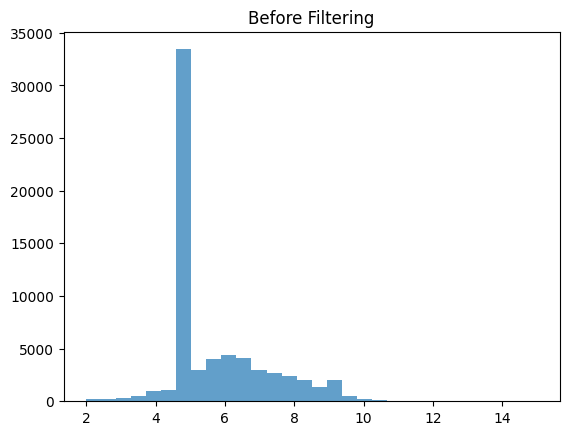

Mode of neg_log10_affinity_M in BindingDB IC50 dataset: 5.00


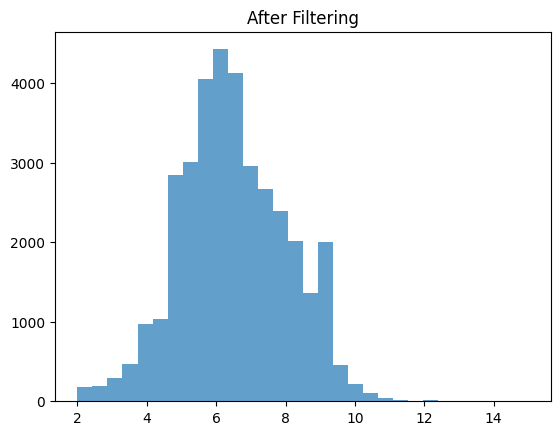

Number of entries after filtering: 35845


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

from statistics import mode
# Read the bindingdb-ic50 dataset
bindingdb_df = pd.read_csv('bindingdb-kd.csv')

# Calculate the mode of neg_log10_affinity_M
mode_affinity = mode([x for x in bindingdb_df['neg_log10_affinity_M'].tolist()])
# Visualize before filtering
plt.hist(bindingdb_df['neg_log10_affinity_M'], bins=30, alpha=0.7)
plt.title('Before Filtering')
plt.show()

print(f"Mode of neg_log10_affinity_M in BindingDB IC50 dataset: {mode_affinity:.2f}")

# set seed
np.random.seed(42)
# Filter out 90% of rows where neg_log10_affinity_M equals 5
mask_value_5 = bindingdb_df['neg_log10_affinity_M'] == 5
rows_to_keep = ~mask_value_5 | (mask_value_5 & (np.random.rand(len(bindingdb_df)) < 0.05))
bindingdb_df = bindingdb_df[rows_to_keep].reset_index(drop=True)

# Visualize after filtering
plt.hist(bindingdb_df['neg_log10_affinity_M'], bins=30, alpha=0.7)
plt.title('After Filtering')
plt.show()

print(f"Number of entries after filtering: {len(bindingdb_df)}")

bindingdb_df.to_csv('bindingdb-kd-filtered.csv', index=False)


In [96]:
import pandas as pd
import glob

# Get all CSV files in current directory
csv_files = glob.glob('*.csv')

# Convert each CSV to parquet
for csv_file in csv_files:
    # Read CSV
    df = pd.read_csv(csv_file)
    
    # Create parquet filename by replacing .csv extension
    parquet_file = csv_file.replace('.csv', '.parquet')
    
    # Save as parquet
    df.to_parquet(parquet_file, index=False)
    print(f"Converted {csv_file} to {parquet_file}")

Converted bindingdb-ki.csv to bindingdb-ki.parquet
Converted pdbbind-2020-refined.csv to pdbbind-2020-refined.parquet
Converted davis-filtered.csv to davis-filtered.parquet
Converted bindingdb-kd-filtered.csv to bindingdb-kd-filtered.parquet
Converted glaser.csv to glaser.parquet
Converted bindingdb-ic50.csv to bindingdb-ic50.parquet
Converted pdbbind-2020-combined.csv to pdbbind-2020-combined.parquet
Converted bindingdb-kd.csv to bindingdb-kd.parquet
Converted davis.csv to davis.parquet
Converted kiba.csv to kiba.parquet


In [3]:
import glob
import pandas as pd
# Print mean affinity values for each dataset
parquet_files = glob.glob('*.parquet')

for parquet_file in parquet_files:
    try:
        df = pd.read_parquet(parquet_file)
        if 'neg_log10_affinity_M' in df.columns:
            mean_affinity = df['neg_log10_affinity_M'].mean()
            print(f"Mean affinity for {parquet_file}: {mean_affinity:.2f}")
    except Exception as e:
        print(f"Could not process {parquet_file}: {str(e)}")



Mean affinity for glaser.parquet: 6.51
Mean affinity for bindingdb-ki.parquet: 6.88
Mean affinity for train.parquet: 6.46
Mean affinity for kiba.parquet: 7.93
Mean affinity for bindingdb-kd-filtered.parquet: 6.50
Mean affinity for pdbbind-2020-combined.parquet: 6.36
Mean affinity for pdbbind-2020-refined.parquet: 6.39
Mean affinity for test_25_targets_40_percent_similarity.parquet: 5.69
Mean affinity for test_1000_drugs.parquet: 6.38
Mean affinity for davis-filtered.parquet: 6.49
Mean affinity for bindingdb-ic50.parquet: 6.37
Mean affinity for test_25_targets_80_percent_similarity.parquet: 5.73
Mean affinity for bindingdb-kd.parquet: 5.81
Mean affinity for davis.parquet: 5.41
Mean affinity for test_25_targets_60_percent_similarity.parquet: 6.75
Mean affinity for affinity-data-combined.parquet: 6.46


In [3]:
import pandas as pd

# Load the combined dataset
df = pd.read_parquet('affinity-data-combined.parquet')

# Calculate mean and std dev
mean_affinity = df['neg_log10_affinity_M'].mean()
std_affinity = df['neg_log10_affinity_M'].std()

print(f"Combined dataset statistics:")
print(f"Mean affinity: {mean_affinity:.4f}")
print(f"Standard deviation: {std_affinity:.4f}")


Combined dataset statistics:
Mean affinity: 6.5416
Standard deviation: 1.5625
